In [1]:
import argparse
import functools as ft
import itertools as it
from localscope import localscope
import logging
logging.basicConfig(level='WARNING')
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pypolychord as pc
import pypolychord.settings
import shedding
from scipy import stats, special
from tqdm.notebook import tqdm
import sys
import pickle

mpl.rcParams['figure.dpi'] = 144

args = os.environ.get('ARGS', "-i -t -s 0 -l 5 -r 1 -f general workspace/test").split()
print(args)
parser = argparse.ArgumentParser()
# Positional
parser.add_argument('parametrisation', type=shedding.Parametrisation, 
                    help='parametrisation to use')
parser.add_argument('basedir')

# Keyword
parser.add_argument('--inflated', '-i', action='store_true', 
                    help='whether to use a zero-inflated model')
parser.add_argument('--temporal', '-t', action='store_true', 
                    help='whether to use a time-dependent model')
parser.add_argument('--force', '-f', action='store_true', 
                    help='force regeneration of samples')
parser.add_argument('--seed', '-s', type=int, help='random number generator seed')
parser.add_argument('--nlive-factor', '-l', type=float, default=25, 
                    help='multiplicative factor for number of live points')
parser.add_argument('--nrepeat-factor', '-r', type=float, default=5, 
                    help='multiplicative factor for number of monte carl steps')
args = parser.parse_args(args)
os.makedirs(args.basedir, exist_ok=True)
args

['-i', '-t', '-s', '0', '-l', '5', '-r', '1', '-f', 'general', 'workspace/test']


Namespace(basedir='workspace/test', force=True, inflated=True, nlive_factor=5.0, nrepeat_factor=1.0, parametrisation=<Parametrisation.GENERAL: 'general'>, seed=0, temporal=True)

In [14]:
# Load and flatten some of the datasets
datasets = [
    'Woelfel2020', 
    'Lui2020', 
    'Han2020',
]
if False:  # Fit only to temporal data because we want to compare models
    datasets.append('Wang2020')
    
datasets = shedding.load_datasets(datasets, 'publications/')
data = shedding.flatten_datasets(datasets, loq_fill_value=-99)
print(f'Number of patients: {data["num_patients"]}')
print(f'Number of patients with one or more positive samples: '
      f'{(data["num_positives_by_patient"] > 0).sum()}')
print(f'Number of samples: {data["num_samples"]}')
print(f'Number of positive samples: {data["positive"].sum()}')

model = shedding.Model(data['num_patients'], parametrisation=args.parametrisation, inflated=args.inflated,
                       temporal=args.temporal)
print(f'Number of parameters: {model.size}')

with open(os.path.join(args.basedir, 'model.pkl'), 'wb') as fp:
    pickle.dump(model, fp)
    
with open(os.path.join(args.basedir, 'data.pkl'), 'wb') as fp:
    pickle.dump(data, fp)

Number of patients: 22
Number of patients with one or more positive samples: 21
Number of samples: 134
Number of positive samples: 98
Number of parameters: 29


In [4]:
settings = pc.settings.PolyChordSettings(model.size, 0)
settings.base_dir = args.basedir
settings.file_root = 'chain'
settings.read_resume = False
settings.feedback = 3
settings.num_repeats = int(args.nrepeat_factor * model.size)
settings.nlive = int(args.nlive_factor * model.size)
settings.seed = -1 if args.seed is None else args.seed
settings.write_resume = False

filename = os.path.join(settings.base_dir, settings.file_root + '.paramnames')
shedding.write_paramnames_file(model.parameters, filename)

vars(settings)

{'nlive': 145,
 'num_repeats': 29,
 'nprior': -1,
 'nfail': -1,
 'do_clustering': True,
 'feedback': 3,
 'precision_criterion': 0.001,
 'logzero': -1e+30,
 'max_ndead': -1,
 'boost_posterior': 0.0,
 'posteriors': True,
 'equals': True,
 'cluster_posteriors': True,
 'write_resume': False,
 'write_paramnames': False,
 'read_resume': False,
 'write_stats': True,
 'write_live': True,
 'write_dead': True,
 'write_prior': True,
 'maximise': False,
 'compression_factor': 0.36787944117144233,
 'base_dir': 'workspace/test',
 'file_root': 'chain',
 'seed': 0,
 'grade_dims': [29],
 'grade_frac': [1.0],
 'nlives': {}}

In [5]:
# Validate that we can sample and evaluate
x = np.random.uniform(size=model.size)
y = model.sample_params_from_vector(x)
model.evaluate_log_likelihood_from_vector(y, data)

(-3580.8751516563098, [])

In [6]:
shedding.vector_to_values(model.parameters, y)

{'population_loc': array(7.1727276),
 'population_scale': array(0.40343037),
 'patient_scale': array(0.91697332),
 'patient_mean': array([ 516.85615881, 2039.12145489, 2115.73664037, 1785.868444  ,
         807.2725952 ,  396.80453345, 1153.35812995, 1283.73189196,
        1171.07934826, 2127.29345207,  378.42928239,  683.51423998,
        1181.56463691,  818.12736439, 1399.59653845,  898.9845917 ,
         752.13942187, 1510.58974898, 1053.07613999, 1883.70525533,
         835.12344795,  241.93644212]),
 'population_shape': array(1.57538297),
 'patient_shape': array(0.07919771),
 'rho': array(0.40971337),
 'slope': array(-0.08975344)}

In [7]:
filename = os.path.join(settings.base_dir, settings.file_root + '.txt')
if os.path.isfile(filename) and not args.force:
    print(f'{filename} already exists; remove it to regenerate samples')
else:
    log_likelihood = ft.partial(model.evaluate_log_likelihood_from_vector, data=data)
    with tqdm() as progress: 
        output = pc.run_polychord(log_likelihood, model.size, 0, settings, model.sample_params_from_vector, 
                                  lambda *args: progress.update())

/Users/till/git/shedding/shedding/model.py:641: RuntimeWarning: divide by zero encountered in gengamma_lloc
  mu = gengamma_loc(q, sigma, values['patient_mean'])
/Users/till/git/shedding/shedding/model.py:646: RuntimeWarning: invalid value encountered in gengamma_lpdf
  lxdf = gengamma_lpdf(q, mu, sigma, data['loadln'], where=data['positive'])
/Users/till/git/shedding/shedding/model.py:646: RuntimeWarning: overflow encountered in gengamma_lpdf
  lxdf = gengamma_lpdf(q, mu, sigma, data['loadln'], where=data['positive'])
/Users/till/git/shedding/shedding/model.py:647: RuntimeWarning: overflow encountered in gengamma_lcdf
  gengamma_lcdf(q, mu, sigma, data['loqln'], out=lxdf, where=~data['positive'])
/Users/till/git/shedding/shedding/model.py:347: RuntimeWarning: overflow encountered in power
  return (special.gammaincinv(a, uniform) / a) ** cinv * np.exp(mu)


In [8]:
samples = np.loadtxt(os.path.join(settings.base_dir, settings.file_root + '_equal_weights.txt'))[:, 2:]
num_samples = len(samples)
print(f'Obtained {num_samples} samples.')
samples = shedding.transpose_samples(samples, model.parameters)

Obtained 1375 samples.


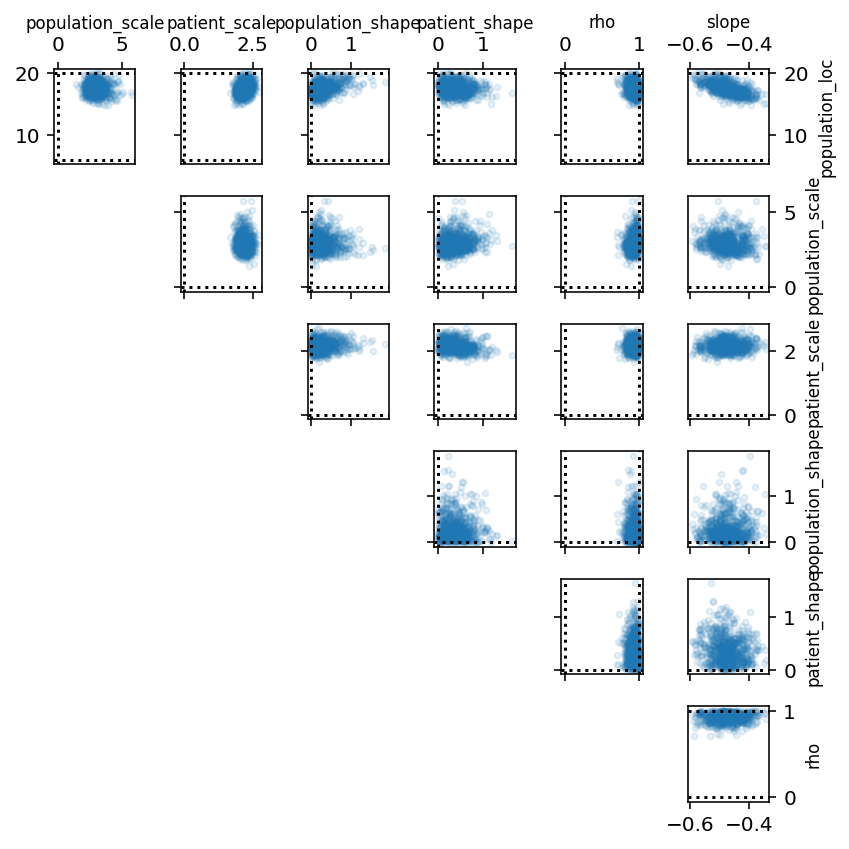

In [9]:
# Create a figure with the right number of columns
model_pars = [par for par, value in samples.items() if not par.endswith('_') and
              np.ndim(value) < 2]
nrows = ncols = len(model_pars) - 1
fig, axes = plt.subplots(nrows, ncols, sharex='col', sharey='row',
                         figsize=(6, 6))

# Iterate over the pairs
step = max(1, num_samples // 500)
for i in range(len(model_pars) - 1):
    a = model_pars[i]
    for j in range(1, len(model_pars)):
        ax = axes[i, j - 1]
        if j <= i:
            ax.set_axis_off()
            continue
            
        b = model_pars[j]
        x = samples[a][::step]
        y = samples[b][::step]

        ax.scatter(y, x, marker='.', alpha=.1)
        if i == 0:
            ax.set_xlabel(b, size='small')
            ax.xaxis.set_label_position('top')
            ax.xaxis.tick_top()
            ax.xaxis.set_tick_params(which='both', labeltop=True)
            
        if j == ncols:
            ax.set_ylabel(a, size='small')
            ax.yaxis.set_label_position('right')
            ax.yaxis.tick_right()
            ax.yaxis.set_tick_params(which='both', labelright=True)
            
        # Draw prior bounds if they exist
        for k, line in zip([b, a], [ax.axvline, ax.axhline]):
            prior = model.priors.get(k)
            if not prior:
                continue
            bounds = prior.bounds
            for bound in bounds:
                if bound is not None:
                    line(bound, color='k', ls=':')
            
fig.tight_layout()

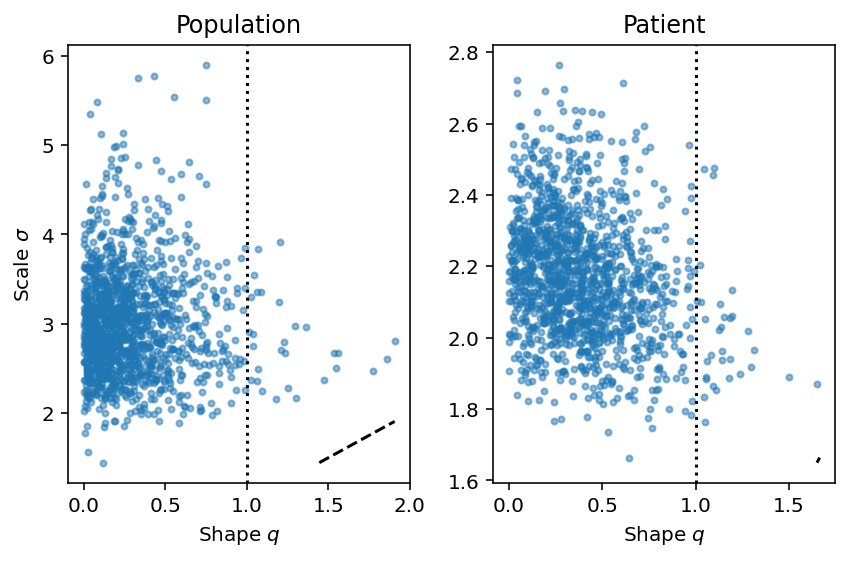

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)
for ax, key in zip((ax1, ax2), ('population', 'patient')):
    a = f'{key}_shape'
    b = f'{key}_scale'
    x = samples[a]
    y = samples[b]
    ax.scatter(x, y, marker='.', alpha=.5)
    ax.set_xlabel(r'Shape $q$')
    
    xmin = max(x.min(), y.min())
    xmax = min(x.max(), y.max())
    lin = np.linspace(xmin, xmax)
    ax.plot(lin, lin, color='k', ls='--')
    
    ax.axvline(1, color='k', ls=':')
    # ax.set_aspect('equal')
    if False:
        ax.set_xscale('log')
        ax.set_yscale('log')
        
ax1.set_ylabel(r'Scale $\sigma$')
ax1.set_title('Population')
ax2.set_title('Patient')
    
fig.tight_layout()

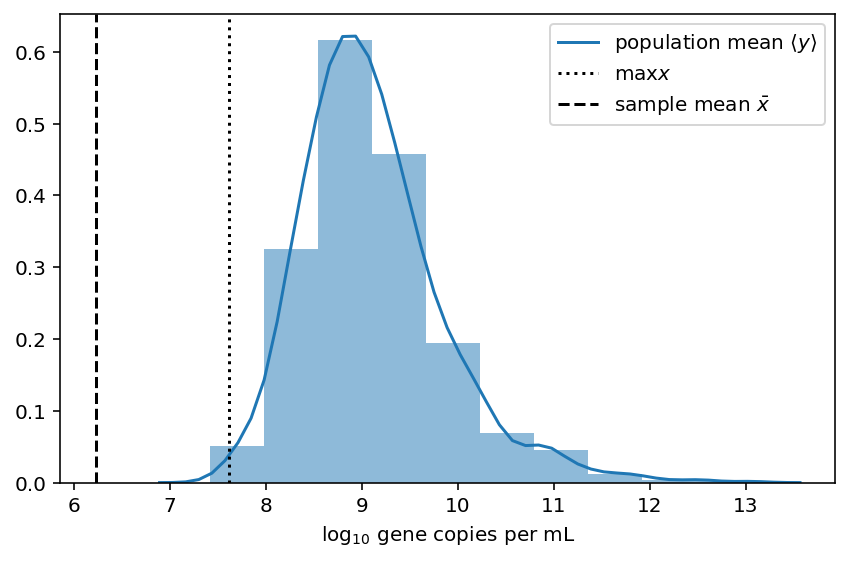

In [11]:
zipped = zip(samples['population_shape'], samples['population_loc'], samples['population_scale'])
x = np.log10([shedding.gengamma_mean(q, mu, sigma) for q, mu, sigma in zipped])
if model.inflated:
    x += np.log10(samples['rho'])

fig, ax = plt.subplots()
ax.hist(x, density=True, alpha=.5)
shedding.plot_kde(x, color='C0', ax=ax, label=r'population mean $\langle y\rangle$')
ax.axvline(np.log10(data['load'].max()), color='k', ls=':', label=r'$\max x$')
ax.axvline(np.log10(data['load'][data['positive']].mean()), color='k', ls='--', 
           label=r'sample mean $\bar x$')
ax.set_xlabel(r'$\log_{10}$ gene copies per mL')
ax.legend()
fig.tight_layout()

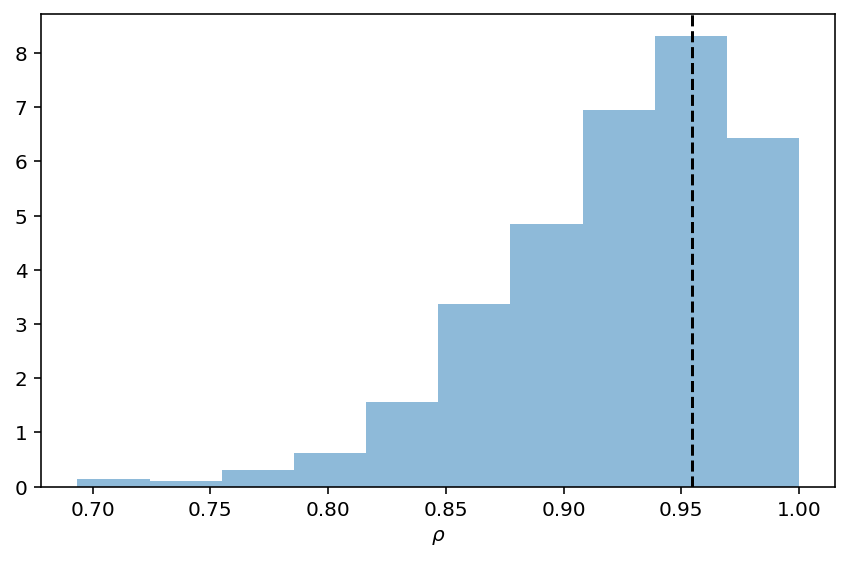

In [12]:
if model.inflated:
    fig, ax = plt.subplots()
    ax.hist(samples['rho'], density=True, range=(samples['rho'].min(), 1), alpha=.5)
    ax.axvline(np.mean(data['num_positives_by_patient'] > 0), color='k', ls='--')
    ax.set_xlabel(r'$\rho$')
    fig.tight_layout()

In [13]:
output.logZ, output.logZerr

(-1270.07815643443, 0.480070571011243)